In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prathamtripathi/drug-classification")

dataset = pd.read_csv(f"{path}/{os.listdir(path)[0]}")
dataset.head()

/home/parth/miniconda3/envs/env-practice-ml-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


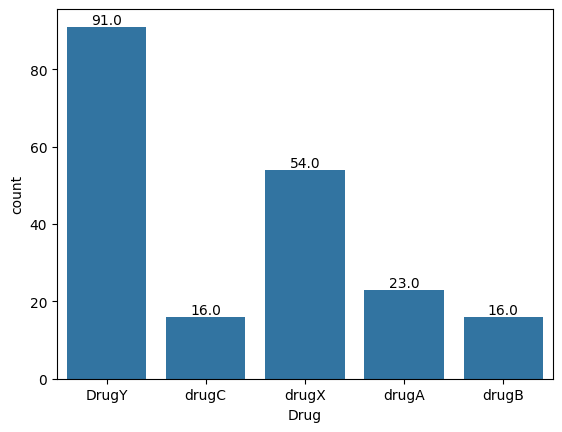

In [3]:
import seaborn as sns

ax = sns.countplot(x="Drug", data=dataset)
for p in ax.patches:
    width = p.get_width()
    x = p.get_x() + width / 2.
    y = p.get_height()
    ax.annotate(p.get_height(), (x, y), ha="center", va="bottom")

In [4]:
categorical_columns = dataset.select_dtypes(include="object").columns

for col in categorical_columns:
    print(f"Total unique values in column '{col}': {(dataset[col].unique())}")

Total unique values in column 'Sex': ['F' 'M']
Total unique values in column 'BP': ['HIGH' 'LOW' 'NORMAL']
Total unique values in column 'Cholesterol': ['HIGH' 'NORMAL']
Total unique values in column 'Drug': ['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


In [5]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in categorical_columns:
    encoders[col] = LabelEncoder()
    dataset[col] = encoders[col].fit_transform(dataset[col])

dataset.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0


In [6]:
dataset.describe()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,44.315000,0.520000,0.910000,0.485000,16.084485,1.595000
std,16.544315,0.500854,0.821752,0.501029,7.223956,1.716305
min,15.000000,0.000000,0.000000,0.000000,6.269000,0.000000
25%,31.000000,0.000000,0.000000,0.000000,10.445500,0.000000
50%,45.000000,1.000000,1.000000,0.000000,13.936500,1.000000
75%,58.000000,1.000000,2.000000,1.000000,19.380000,4.000000
max,74.000000,1.000000,2.000000,1.000000,38.247000,4.000000


In [7]:
from sklearn.preprocessing import StandardScaler

normalize_columns = ["Age", "Na_to_K"]
scaler = StandardScaler()
dataset[normalize_columns] = scaler.fit_transform(dataset[normalize_columns])

dataset.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,-1.291591,0,0,0,1.286522,0
1,0.162699,1,1,0,-0.415145,3
2,0.162699,1,1,0,-0.828558,3
3,-0.988614,0,2,0,-1.149963,4
4,1.011034,0,1,0,0.271794,0


In [8]:
print(f"Dataset size: {dataset.shape[0]}")

Dataset size: 200


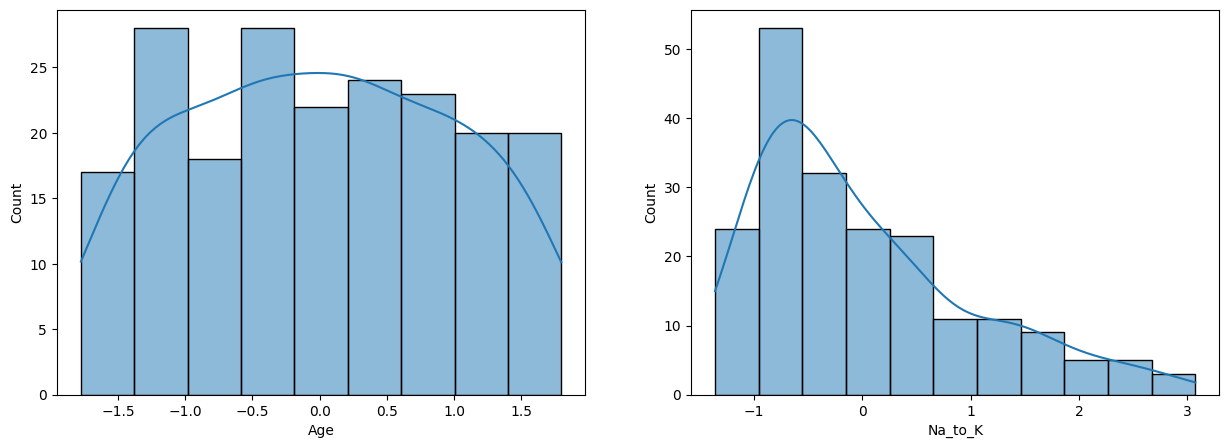

In [9]:
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

for i, column in enumerate(normalize_columns):
    sns.histplot(dataset[column], kde=True, ax=axes[i])

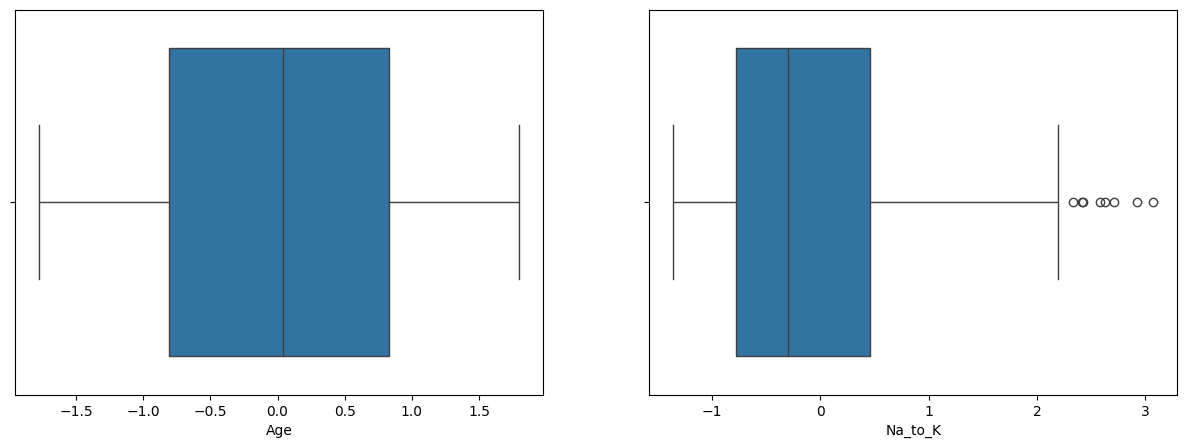

In [10]:
_, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

for i, col in enumerate(normalize_columns):
    _ = sns.boxplot(x=col, data=dataset, ax=axes[i])

In [11]:
from sklearn.model_selection import train_test_split

X = dataset.drop(columns=["Drug"], axis=1, inplace=False)
y = dataset[["Drug"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

print(f"Train dataset size: {X_train.shape[0]}")
print(f"Test dataset size: {X_test.shape[0]}")

Train dataset size: 160
Test dataset size: 40


In [12]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion="log_loss",
    splitter="best",
    max_depth=10,
    max_features=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train, check_input=True)

DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=5, random_state=42)

In [13]:
from sklearn.metrics import balanced_accuracy_score as bas

y_pred = model.predict(X_test)
print(f"Balanced accuracy: {bas(y_test, y_pred, adjusted=True) * 100:.2f}%")

Balanced accuracy: 97.73%


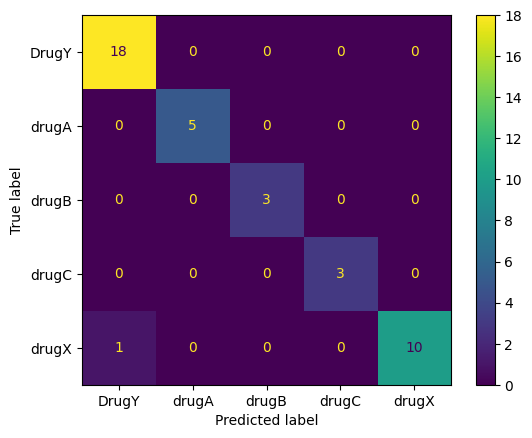

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=encoders["Drug"].inverse_transform(model.classes_)
).plot()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40

